In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn
import random


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [3]:
filename = 'Dataset/Sensor_Discrimination_normalized.csv'
df=pd.read_csv(filename)
# shuffle the DataFrame rows
df = df.sample(frac = 1) #frac = fraction
dataset=df.iloc[:,:-1]
label=df.iloc[:,-1]
print(dataset)
print(label)

            F2        F3        F1       F11        F4        F6       F10  \
538   0.563422  0.771198  0.586092  0.177482  0.554299  0.179192  0.192959   
1652  0.458182  0.567799  0.341038  0.170550  0.498586  0.062754  0.242658   
801   0.145711  0.942799  0.888541  0.222872  0.869283  0.576141  0.417922   
1236  0.985455  0.888964  0.826641  0.231206  0.927158  0.405992  0.576995   
577   0.277647  0.803836  0.629775  0.175957  0.532846  0.252996  0.202184   
...        ...       ...       ...       ...       ...       ...       ...   
1345  0.516578  0.501682  0.292262  0.178723  0.333943  0.026509  0.273720   
1145  0.296043  0.936743  0.900098  0.418972  0.981706  0.638813  0.939006   
1085  0.103658  0.964334  0.956905  0.869504  0.973225  0.761682  0.968185   
115   0.515722  0.468203  0.225465  0.186348  0.419258 -0.048323  0.202748   
94    0.213070  0.948183  0.910872  0.947518  0.966739  0.592358  0.948607   

            F9        F5        F7     F12       F8  
538   0.1

In [4]:
pcaTrain = PCA(n_components=3).fit(dataset)# --train-- pca with the "dataset" Dataframe
print(pcaTrain)
compressed_dataset_X= pcaTrain.transform(dataset) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X))
print(len(compressed_dataset_X[0]))
print(compressed_dataset_X)

PCA(n_components=3)
<class 'numpy.ndarray'>
3
[[ 1.44846284 -0.66793765  0.05415401]
 [ 1.43102076 -0.93292218  0.052994  ]
 [ 1.62030511  0.26968846 -0.17328786]
 ...
 [-3.18885563  0.93058917 -0.19736482]
 [ 1.33189194 -0.98216726  0.2860426 ]
 [ 0.84066414  1.03258081 -0.15942413]]


In [38]:
dataset_arr=dataset.to_numpy()
# from NecessaryModules.splitData import split_data
X_train, X_test, y_train, y_test = train_test_split(dataset_arr, label, test_size=0.3, random_state=42)
print(len(X_train))

1548


In [6]:
compressed_dataset_X_train= pcaTrain.transform(X_train) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_train))
print(len(compressed_dataset_X_train))
print(compressed_dataset_X_train)

compressed_dataset_X_test= pcaTrain.transform(X_test) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_test))
print(len(compressed_dataset_X_test))
print(compressed_dataset_X_test)

<class 'numpy.ndarray'>
1548
[[ 1.45879748 -0.00614019 -0.235758  ]
 [ 1.10300891 -0.23092005 -0.1927999 ]
 [ 1.48174025 -0.27736318 -0.20428018]
 ...
 [-2.97157031  0.6828857   0.02673326]
 [-2.89237525 -0.31228889  0.06392068]
 [ 1.5289556  -0.45564981 -0.08237633]]
<class 'numpy.ndarray'>
664
[[ 1.67141655 -0.88392038  0.32217947]
 [ 1.08184202 -0.87188756  0.30565644]
 [ 1.35249258 -0.67460978  0.18500693]
 ...
 [-3.232923    1.7037143   0.73794414]
 [ 1.54742562 -0.10693992 -0.28044131]
 [ 1.38528539  1.17964127 -0.10983542]]


# tune Random-Forest model

In [7]:
# train the model with random parameter
from sklearn.ensemble import RandomForestClassifier
# Preparing the regressor and fitting data with some parameters
model = RandomForestClassifier(

    criterion="entropy",
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=25,
    n_estimators=348,
) 

model.fit(compressed_dataset_X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=25, n_estimators=348)

In [8]:
# Finding mean absolute error
preds = model.predict(compressed_dataset_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.060240963855421686

In [9]:
# Defining the best parameter with optuna
from sklearn.model_selection import KFold
K = 5 # 5 fold cross validation
kf = KFold(n_splits = K, random_state = 42, shuffle = True)


train_tunned = np.array(compressed_dataset_X)
target_train_tunned = np.array(label)

# test = np.array(X)
# target_train = df_train['congestion'].values

# test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective(trial):

 for train_index, val_index in (kf.split(compressed_dataset_X)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    
        
        # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25,random_state=0)
    param = {
            'n_estimators':trial.suggest_int('n_estimators',50,500),
            'criterion':trial.suggest_categorical('criterion',['gini', 'entropy', 'log_loss']),
            'max_depth':trial.suggest_int('max_depth',20,50),
            'min_samples_split':2,
            'min_samples_leaf':1,
            'max_features':trial.suggest_categorical('max_features',['sqrt', 'log2', None]),
            'random_state':trial.suggest_int('random_state',0,10),
       
      
        }
    model = RandomForestClassifier(**param)  
        
    model.fit(train_X,train_Y)
        
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X


 
 print(len(oof_preds))
      
 mae = mean_absolute_error(target_train_tunned, oof_preds)
        
 return mae

In [10]:
# this is the main optuna for optimizing a object-->"objective"
study = optuna.create_study(direction='minimize',study_name="XG_tune")

[I 2024-03-01 12:55:30,839] A new study created in memory with name: XG_tune


In [11]:

study.optimize(objective, n_trials=5) # 150 bar "objective" object ke trial kore kore dekhbe, here total 5*100=750
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-03-01 12:55:32,364] Trial 0 finished with value: 0.05786618444846293 and parameters: {'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 42, 'max_features': None, 'random_state': 5}. Best is trial 0 with value: 0.05786618444846293.


2212


[I 2024-03-01 12:55:41,667] Trial 1 finished with value: 0.05515370705244123 and parameters: {'n_estimators': 321, 'criterion': 'entropy', 'max_depth': 44, 'max_features': None, 'random_state': 4}. Best is trial 1 with value: 0.05515370705244123.


2212


[I 2024-03-01 12:55:44,275] Trial 2 finished with value: 0.054249547920433995 and parameters: {'n_estimators': 158, 'criterion': 'entropy', 'max_depth': 46, 'max_features': 'sqrt', 'random_state': 2}. Best is trial 2 with value: 0.054249547920433995.


2212


[I 2024-03-01 12:55:50,981] Trial 3 finished with value: 0.05244122965641953 and parameters: {'n_estimators': 396, 'criterion': 'entropy', 'max_depth': 41, 'max_features': 'log2', 'random_state': 0}. Best is trial 3 with value: 0.05244122965641953.


2212


[I 2024-03-01 12:55:57,535] Trial 4 finished with value: 0.05334538878842676 and parameters: {'n_estimators': 420, 'criterion': 'log_loss', 'max_depth': 25, 'max_features': 'log2', 'random_state': 8}. Best is trial 3 with value: 0.05244122965641953.


2212
Number of finished trials: 5
Best trial: {'n_estimators': 396, 'criterion': 'entropy', 'max_depth': 41, 'max_features': 'log2', 'random_state': 0}


In [12]:
#evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  5
Best trial:
  Value:  0.05244122965641953
  Params: 
    n_estimators: 396
    criterion: entropy
    max_depth: 41
    max_features: log2
    random_state: 0


# fit the Random-Forest

In [13]:

K2 = 10 # 5 fold cross validation
kf2 = KFold(n_splits = K2, random_state = 42, shuffle = True)

In [14]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train = np.array(compressed_dataset_X_train)
target_train = np.array(y_train)

test = np.array(compressed_dataset_X_test)
target_test = np.array(y_test)

# error_going_up=0

test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train)))

for train_index, val_index in tqdm(kf.split(compressed_dataset_X_train), total=5):
    train_X, valid_X = train[train_index], train[val_index]
    train_y, valid_y = target_train[train_index], target_train[val_index]
    rf_params = study.best_trial.params
    model = RandomForestClassifier(**rf_params,warm_start=True)
    model.fit(train_X, train_y)
    # for train accuracy
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds
    # for test accuracy
    preds_test = model.predict(test)
    test_preds += (preds_test)/5

    # #early_stopping
    # preds_train = model.predict(train_X)
    # error_going_up=EarlyStopping(valid_y,preds,train_y,preds_train,error_going_up=0)
    # if error_going_up==EARLY_STOP_NUM:
    #     print('early stopping occurs!!')
    #     break

print(np.abs(oof_preds-target_train).mean())

100%|██████████| 5/5 [00:05<00:00,  1.06s/it]

0.047157622739018086


In [15]:
from sklearn.metrics import accuracy_score
# valid_Acc_SVC=accuracy_score(target_train,oof_preds)
# print(valid_Acc_SVC)

# another technique for calculate test accuracy
test_Acc_SVC=accuracy_score(target_test,test_preds.round())
print(test_Acc_SVC)

0.947289156626506


In [16]:
#validation accuracy
valid_Acc=accuracy_score(target_train,oof_preds)
print(valid_Acc)

0.9593023255813954


In [17]:
# train accuracy
train_Acc=model.score(compressed_dataset_X_train,y_train)
print(train_Acc)

0.9903100775193798


In [18]:
# test_accuracy
test_Acc=model.score(compressed_dataset_X_test,y_test)
print(test_Acc)

0.9518072289156626


# ROC

In [19]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [20]:
# Binarize the output
y_train = label_binarize(y_train,classes=[0,1,2])
n_classes = y_train.shape[1]
print(n_classes)
print(y_train[0])

3
[0 1 0]


In [21]:
# Binarize the output (y_test)
y_test = label_binarize(y_test,classes=[0,1,2])
n_classes = y_test.shape[1]
print(n_classes)
print(y_test[0])

3
[1 0 0]


In [22]:
# Learn to predict each class against the other
from sklearn.neural_network import MLPClassifier
clf = model
classifier = OneVsRestClassifier(clf)

# Train the classifier
classifier.fit(compressed_dataset_X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(criterion='entropy',
                                                     max_depth=41,
                                                     max_features='log2',
                                                     n_estimators=396,
                                                     random_state=0,
                                                     warm_start=True))

In [23]:
# Compute ROC curve and ROC area for each class
fpr = dict() #dictionary
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], classifier.predict_proba(compressed_dataset_X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

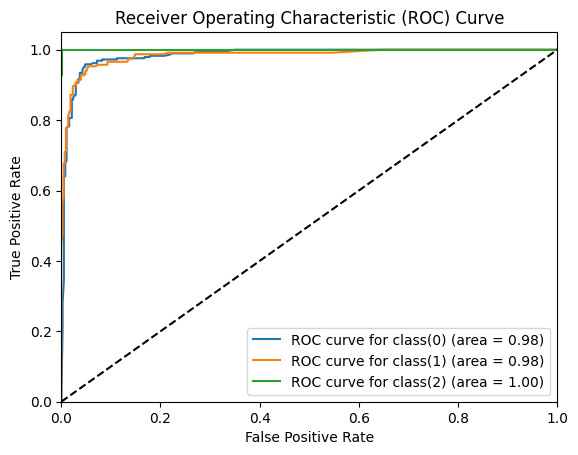

In [24]:
# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve for class(%i) (area = %0.2f)' % (i,roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="best")
plt.show()

# CM

In [30]:
test_preds.round()

array([0., 0., 0., 0., 2., 0., 2., 0., 2., 0., 2., 2., 0., 0., 0., 0., 2.,
       0., 0., 0., 2., 0., 2., 1., 1., 1., 0., 0., 2., 0., 0., 1., 1., 1.,
       2., 0., 1., 1., 1., 1., 2., 1., 0., 2., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 2., 2., 1.,
       1., 1., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 2., 1., 2., 1., 2.,
       0., 2., 1., 1., 0., 0., 0., 0., 2., 1., 2., 1., 1., 1., 1., 2., 1.,
       1., 0., 2., 0., 1., 0., 2., 2., 0., 2., 1., 2., 1., 0., 0., 1., 1.,
       0., 0., 1., 1., 0., 0., 2., 2., 1., 0., 0., 2., 0., 2., 1., 0., 1.,
       1., 2., 1., 0., 1., 0., 2., 1., 2., 2., 2., 1., 2., 0., 0., 1., 1.,
       1., 0., 2., 1., 0., 0., 1., 0., 0., 0., 2., 2., 2., 0., 2., 0., 0.,
       0., 2., 1., 1., 0., 1., 1., 2., 1., 2., 1., 1., 1., 0., 1., 2., 0.,
       2., 1., 0., 0., 1., 1., 1., 1., 2., 0., 0., 1., 1., 1., 0., 0., 2.,
       1., 2., 2., 1., 0., 1., 2., 1., 1., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 2., 1., 2.

In [34]:
y_test.shape

(664, 3)

In [37]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_test=lb.inverse_transform(y_test)

NotFittedError: This LabelBinarizer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [42]:
from sklearn import metrics

cm = metrics.confusion_matrix(target_test, test_preds.round())
cm

array([[268,  20,   1],
       [ 12, 221,   1],
       [  1,   0, 140]], dtype=int64)

In [43]:
cm=[[285,3,1],
    [0,233,1],
    [1,0,140]]

In [46]:
cm=np.array(cm)
cm

array([[285,   3,   1],
       [  0, 233,   1],
       [  1,   0, 140]])

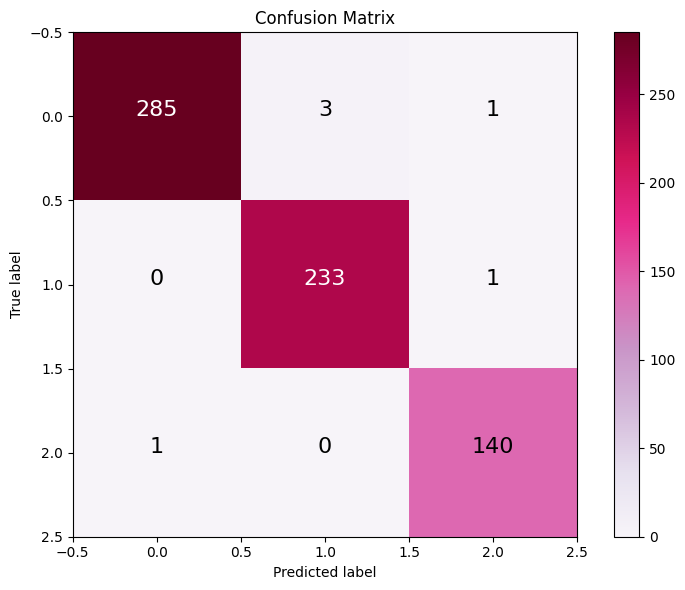

In [50]:
############# plot confusion matrix ############

from matplotlib import pyplot as plt
# from sklearn import metrics

# cm = metrics.confusion_matrix(target_test, test_preds.round())
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",fontsize=16,
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()


# others

In [54]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have defined y_true (true labels) and y_pred (predicted labels) elsewhere in your code

# Calculate precision, recall, and F1 score
precision = precision_score(target_test, test_preds.round(), average='weighted')  # Calculate precision
recall = recall_score(target_test, test_preds.round(), average='weighted')  # Calculate recall
f1 = f1_score(target_test, test_preds.round(), average='weighted')  # Calculate F1 score

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.9476278473020285
Recall: 0.947289156626506
F1 Score: 0.9473040086699784


In [59]:
import numpy as np

# Assuming cm is the confusion matrix
# Assuming you have defined target_test and test_preds elsewhere in your code

# Calculate precision, recall, and F1 score from the confusion matrix
def calculate_metrics(cm):
    # Precision = TP / (TP + FP)
    precision = np.diag(cm) / np.sum(cm, axis=0)

    # Recall = TP / (TP + FN)
    recall = np.diag(cm) / np.sum(cm, axis=1)

    # F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
    f1 = 2 * (precision * recall) / (precision + recall)

    # Handle possible NaN values due to division by zero
    precision = np.nan_to_num(precision)
    recall = np.nan_to_num(recall)
    f1 = np.nan_to_num(f1)

    return precision, recall, f1

precision, recall, f1 = calculate_metrics(cm)

print("Precision:", sum(precision)/len(precision))
print("Recall:", sum(recall)/len(recall))
print("F1 Score:", sum(f1)/len(f1))

Precision: 0.9899023750181545
Recall: 0.9915978222317028
F1 Score: 0.9907310009381445
